# Effect of the smoothing factor

In [1]:
import pymultipleis.multieis as pym

In [2]:
import numpy as onp
import jax.numpy as jnp

In [3]:
# Load the file containing the frequencies
F_her = jnp.asarray(onp.load('../../../data/her_50/freq_50.npy'), dtype=jnp.float64)
# Load the file containing the admittances (a set of 50 spectra)
Y_her = jnp.asarray(onp.load('../../../data/her_50/Y_50.npy'))
Yerr = jnp.asarray(onp.load('../../../data/her_50/sigma_Y_50.npy'))

In [4]:
def her(p, f):
    w = 2*jnp.pi*f
    s = 1j * w  
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rad = p[3]
    Cad= p[4]
    nad= p[5]
    Rct= p[6]
    Wct=p[7] 
    Zw = Wct/jnp.sqrt(w) * (1-1j)
    Zct   = Rad + Zw  
    Yca=(((s**nad)*Cad) + Rct**-1)
    Z1=(Yca**-1 +Zct)
    Y1=(Z1**-1)
    Ydl= ((s**nh)*Qh)
    Z = (Rs + (Ydl + Y1)**-1) 
    Y = 1/Z
    return jnp.concatenate((Y.real, Y.imag), axis = 0)



In [5]:
p0 = jnp.asarray([4.72774187e+02, 9.70785283e-07, 6.51261304e-01,
             1.04825669e+03, 7.27786796e-07, 8.33955442e-01,
             5.98926963e+04, 2.03231984e+04], dtype = jnp.float64)

bounds = [[1e-3,  1e6], [1e-9, 1e-1], [1e-1, 1], [1e-5, 1e8], [1e-9,  1e-1], [1e-1, 1], [1e-5,  1e8], [1e-5,  1e8]]
smf_sigma = jnp.full((len(p0),),1000000.0)
smf_modulus = jnp.full((len(p0),),1.0)

In [6]:
eis_her_simultaneous = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')


Using initial

Optimization complete
total time is 0:00:11.597773 

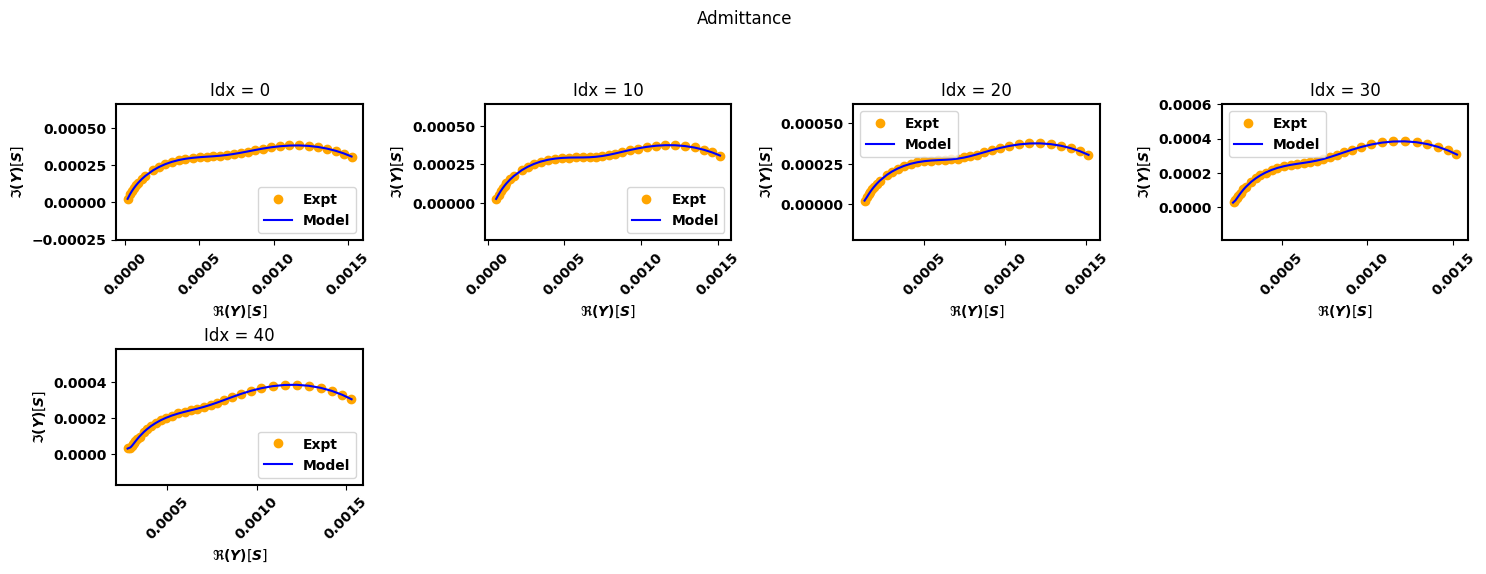

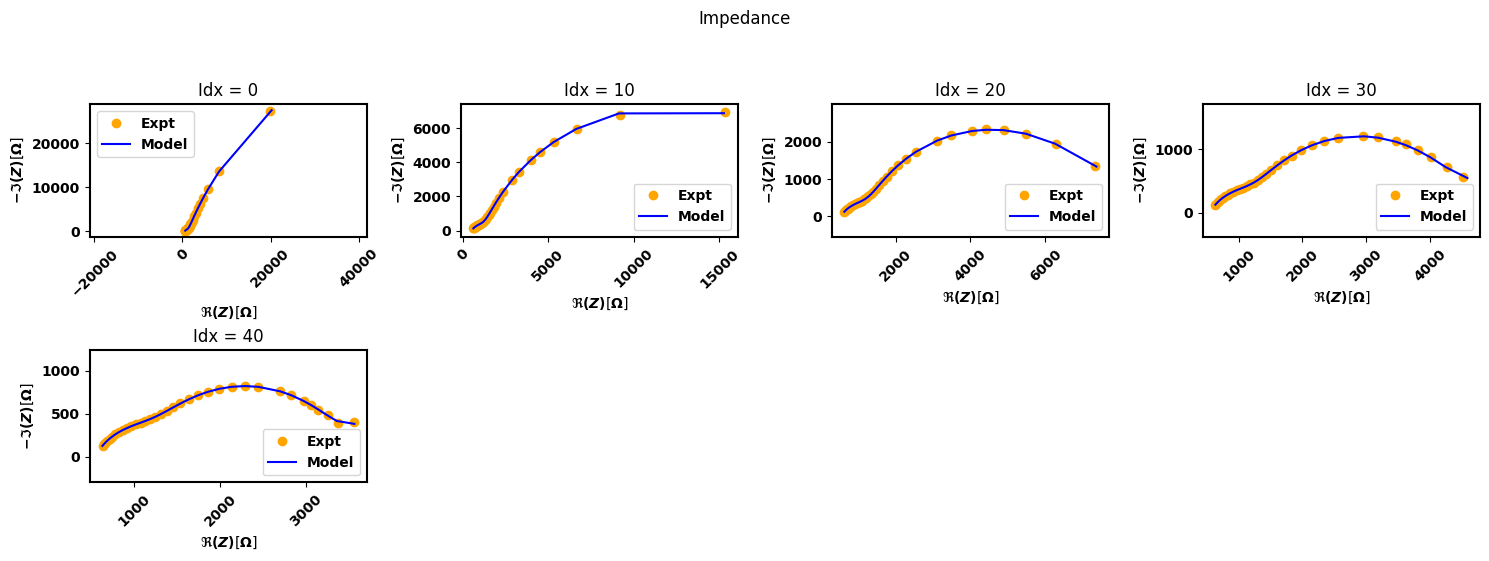

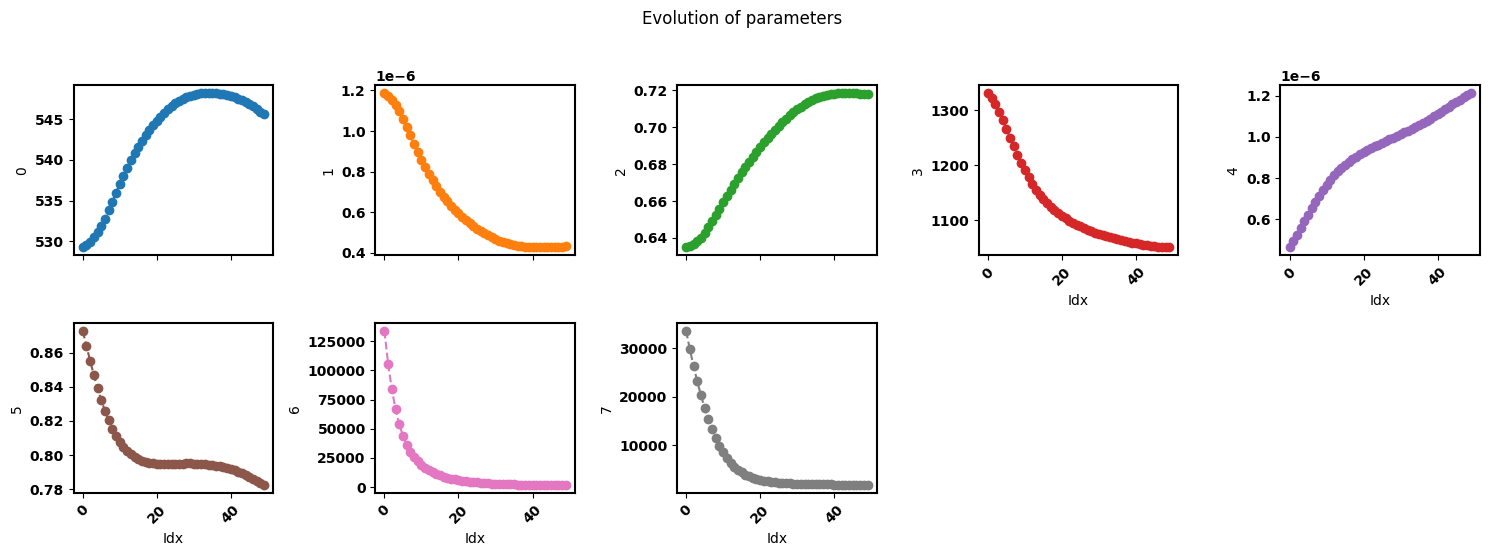

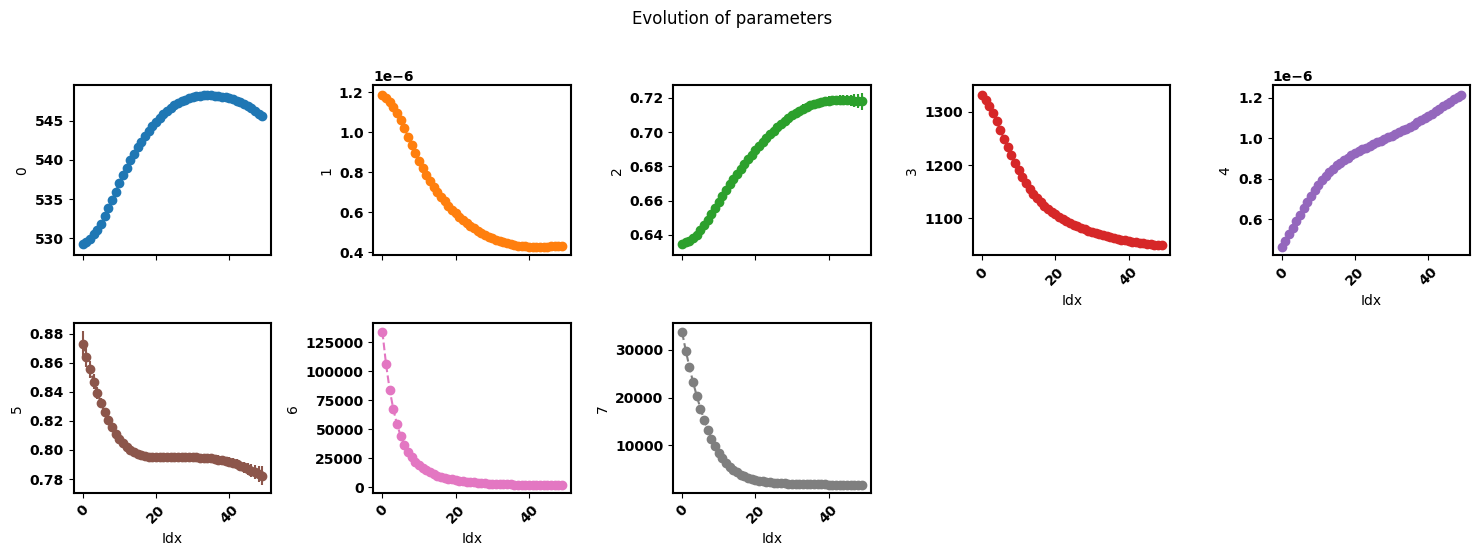

In [7]:
popt, perr, chisqr, chitot, AIC = eis_her_simultaneous.fit_simultaneous()
eis_her_simultaneous.plot_nyquist(10)
eis_her_simultaneous.plot_params()
eis_her_simultaneous.plot_params(show_errorbar=True)


Using initial
fitting spectra 0
fitting spectra 1
fitting spectra 2
fitting spectra 3
fitting spectra 4
fitting spectra 5
fitting spectra 6
fitting spectra 7
fitting spectra 8
fitting spectra 9
fitting spectra 10
fitting spectra 11
fitting spectra 12
fitting spectra 13
fitting spectra 14
fitting spectra 15
fitting spectra 16
fitting spectra 17
fitting spectra 18
fitting spectra 19
fitting spectra 20
fitting spectra 21
fitting spectra 22
fitting spectra 23
fitting spectra 24
fitting spectra 25
fitting spectra 26
fitting spectra 27
fitting spectra 28
fitting spectra 29
fitting spectra 30
fitting spectra 31
fitting spectra 32
fitting spectra 33
fitting spectra 34
fitting spectra 35
fitting spectra 36
fitting spectra 37
fitting spectra 38
fitting spectra 39
fitting spectra 40
fitting spectra 41
fitting spectra 42
fitting spectra 43
fitting spectra 44
fitting spectra 45
fitting spectra 46
fitting spectra 47
fitting spectra 48
fitting spectra 49

Optimization complete
total time is 0:01:00.

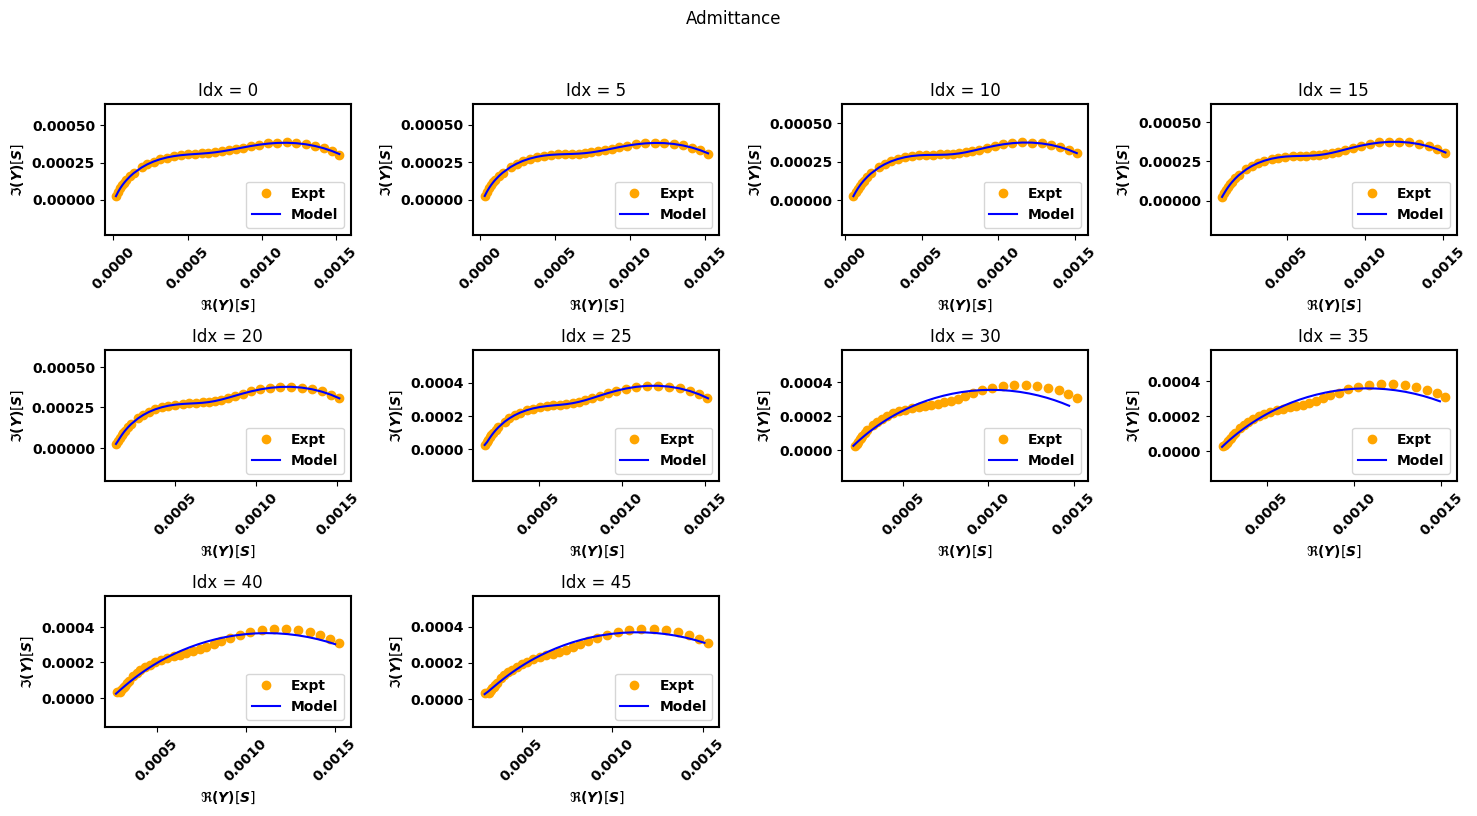

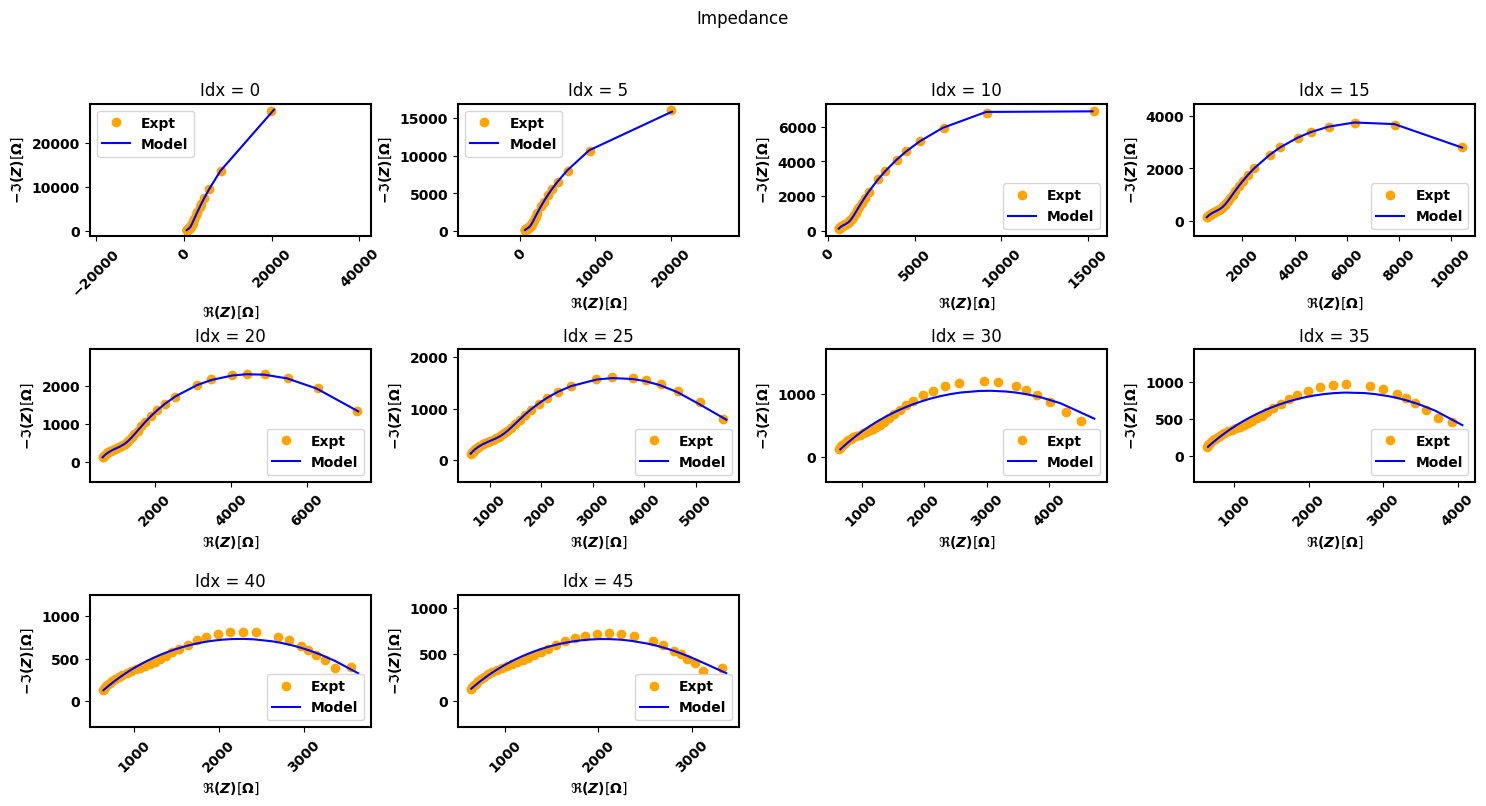

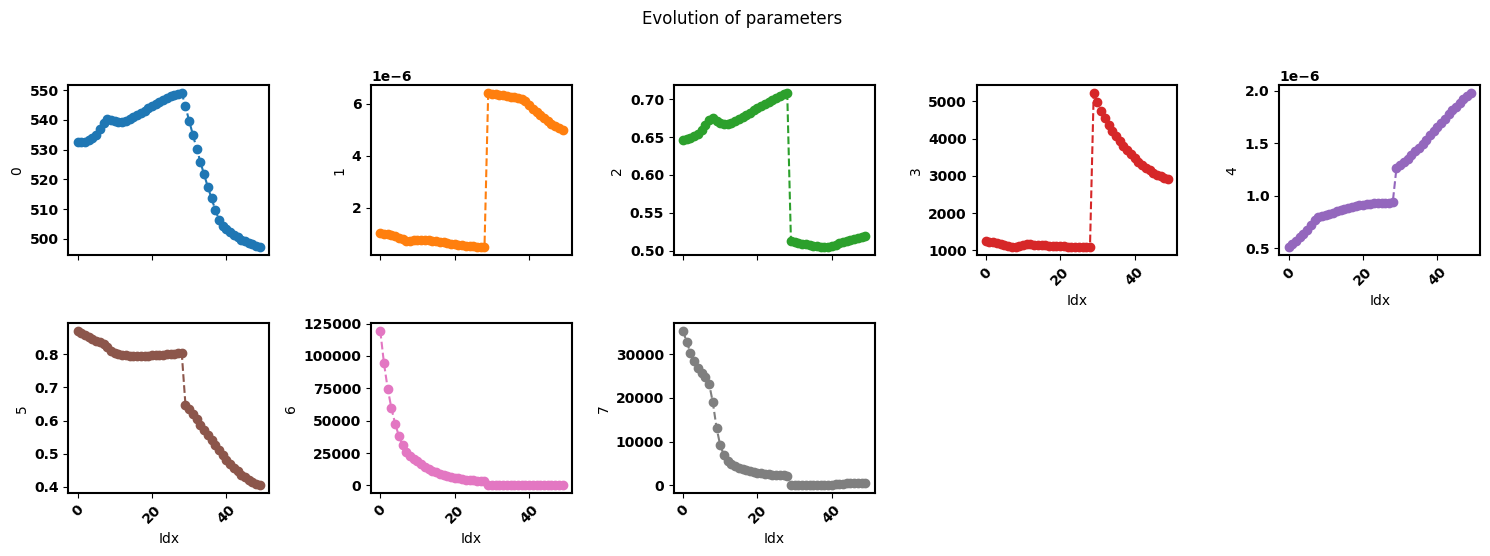

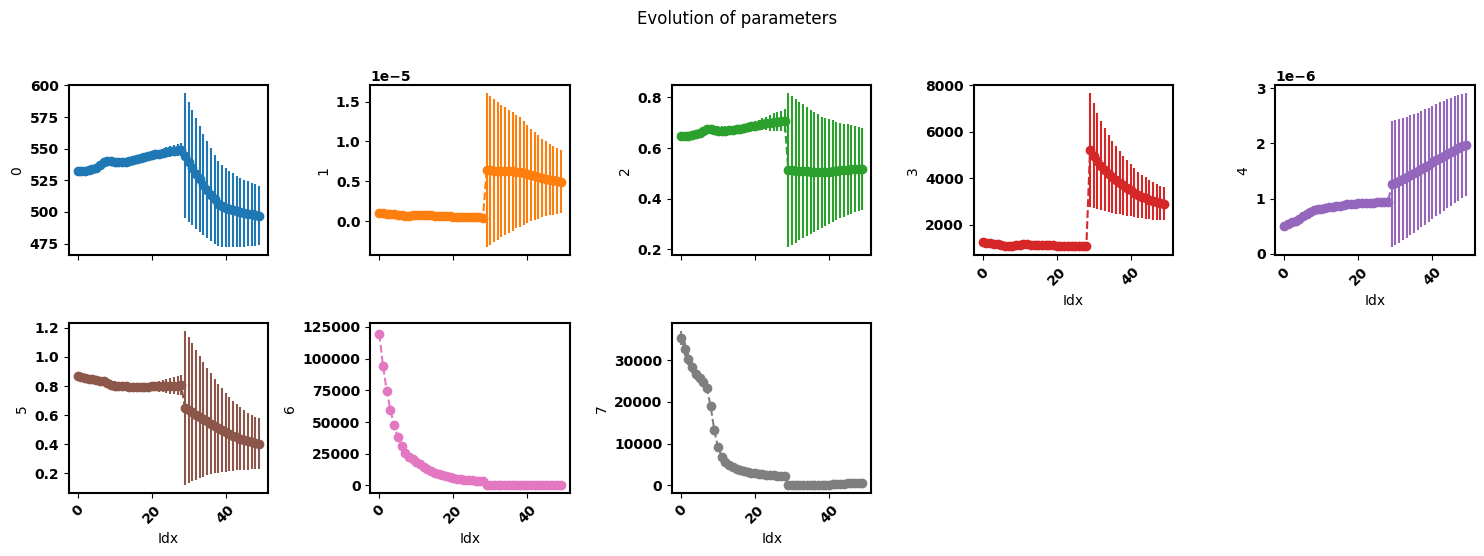

In [8]:
eis_her_sequential = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= Yerr, immittance='admittance')
eis_her_sequential.fit_sequential()
eis_her_sequential.plot_nyquist(5)
eis_her_sequential.plot_params()
eis_her_sequential.plot_params(show_errorbar=True)


Using initial

Optimization complete
total time is 0:00:05.488774 
Using prefit
fitting spectra 0
fitting spectra 1
fitting spectra 2
fitting spectra 3
fitting spectra 4
fitting spectra 5
fitting spectra 6
fitting spectra 7
fitting spectra 8
fitting spectra 9
fitting spectra 10
fitting spectra 11
fitting spectra 12
fitting spectra 13
fitting spectra 14
fitting spectra 15
fitting spectra 16
fitting spectra 17
fitting spectra 18
fitting spectra 19
fitting spectra 20
fitting spectra 21
fitting spectra 22
fitting spectra 23
fitting spectra 24
fitting spectra 25
fitting spectra 26
fitting spectra 27
fitting spectra 28
fitting spectra 29
fitting spectra 30
fitting spectra 31
fitting spectra 32
fitting spectra 33
fitting spectra 34
fitting spectra 35
fitting spectra 36
fitting spectra 37
fitting spectra 38
fitting spectra 39
fitting spectra 40
fitting spectra 41
fitting spectra 42
fitting spectra 43
fitting spectra 44
fitting spectra 45
fitting spectra 46
fitting spectra 47
fitting spectra 4

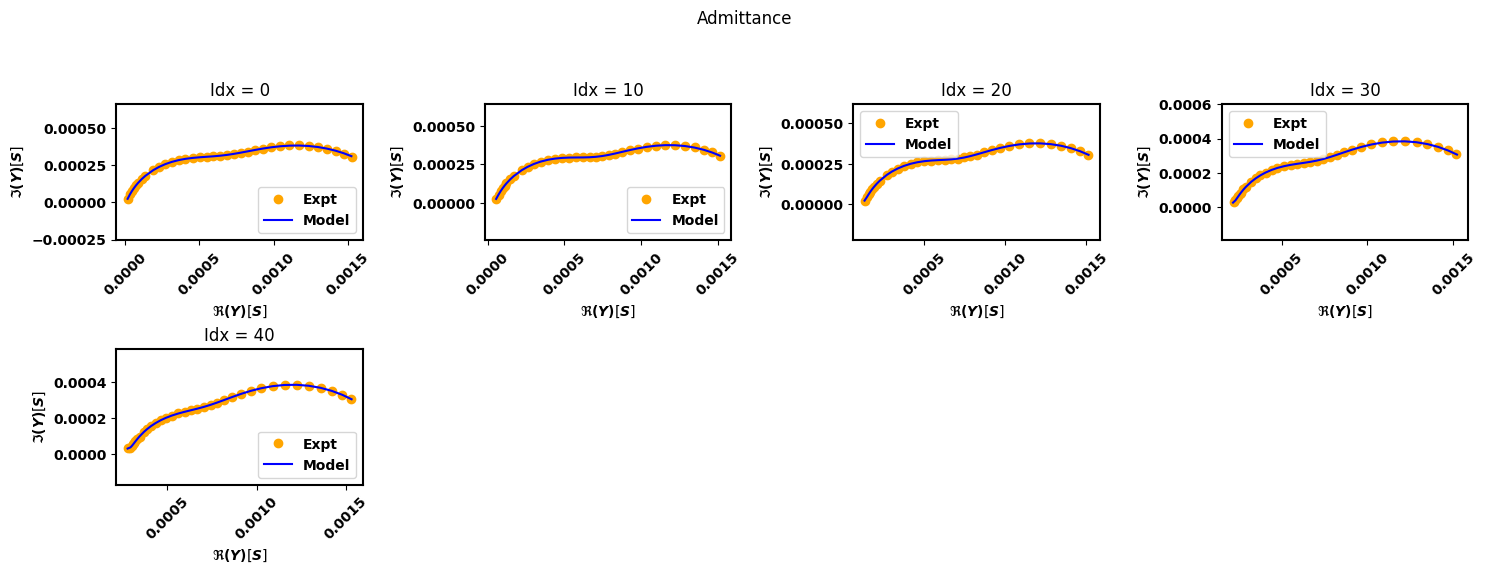

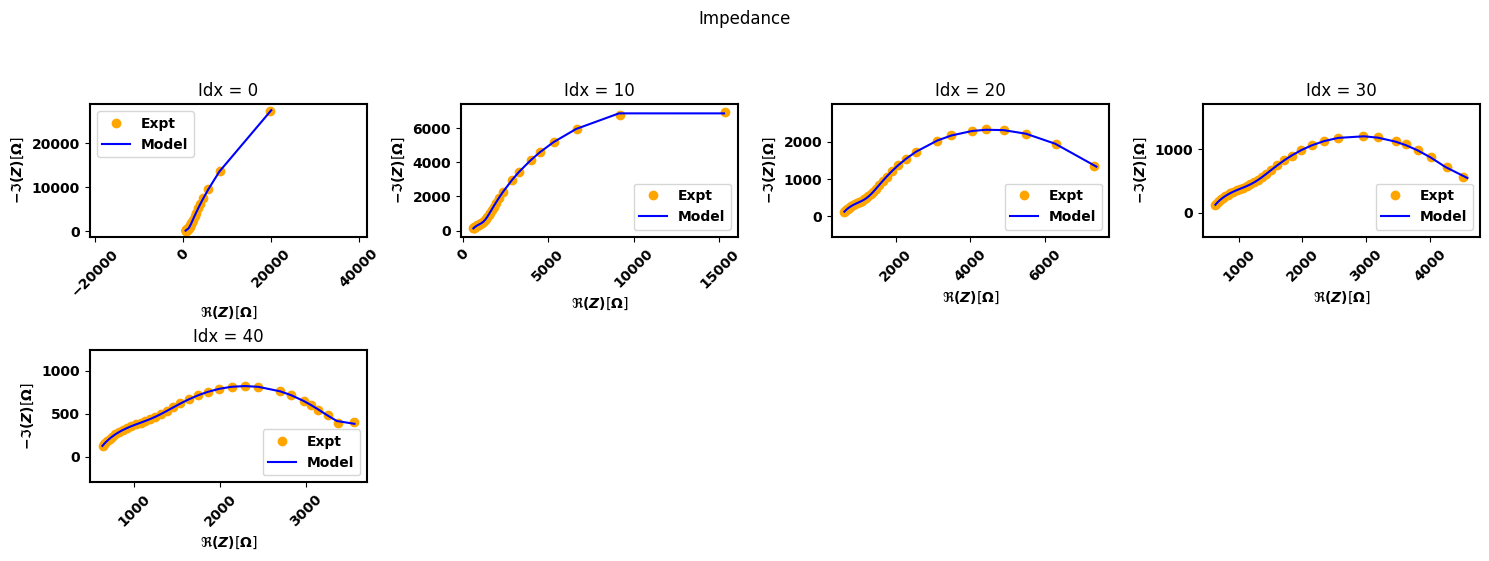

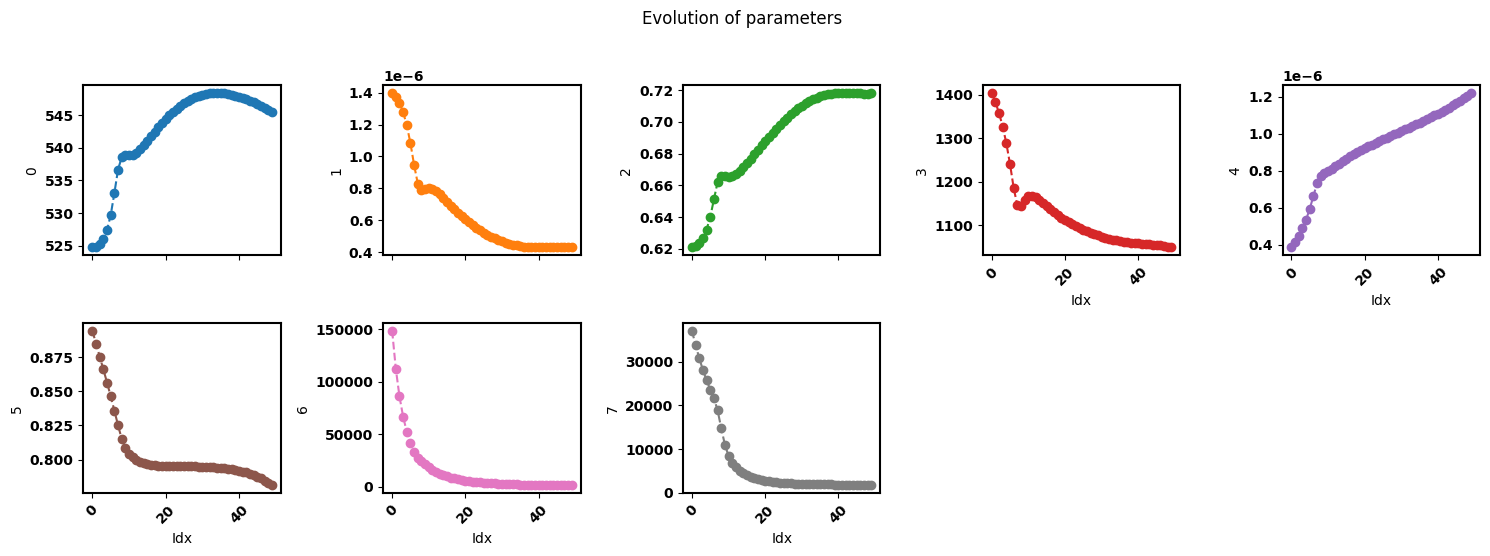

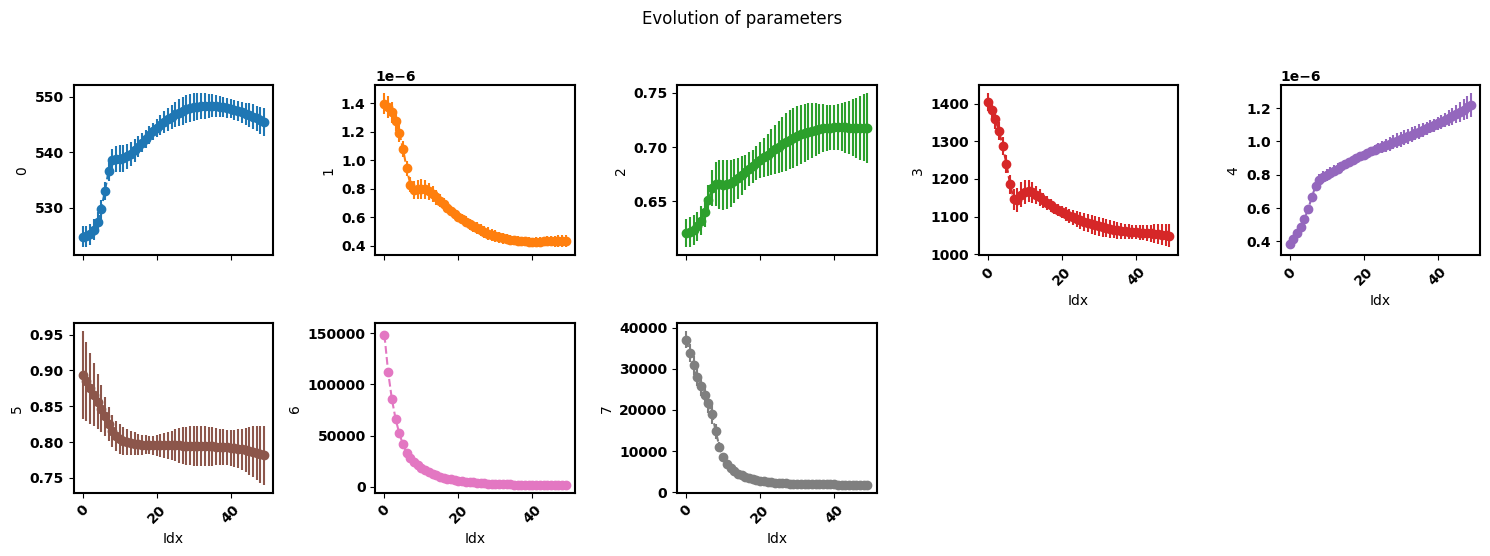

In [9]:
eis_her_simultaneous = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her_simultaneous.fit_simultaneous()
popt, perr, chisqr, chitot, AIC = eis_her_simultaneous.fit_sequential()
eis_her_simultaneous.plot_nyquist(10)
eis_her_simultaneous.plot_params()
eis_her_simultaneous.plot_params(show_errorbar=True)


Using initial

Optimization complete
total time is 0:00:05.918544 
Using prefit

Optimization complete
total time is 0:00:06.978554 

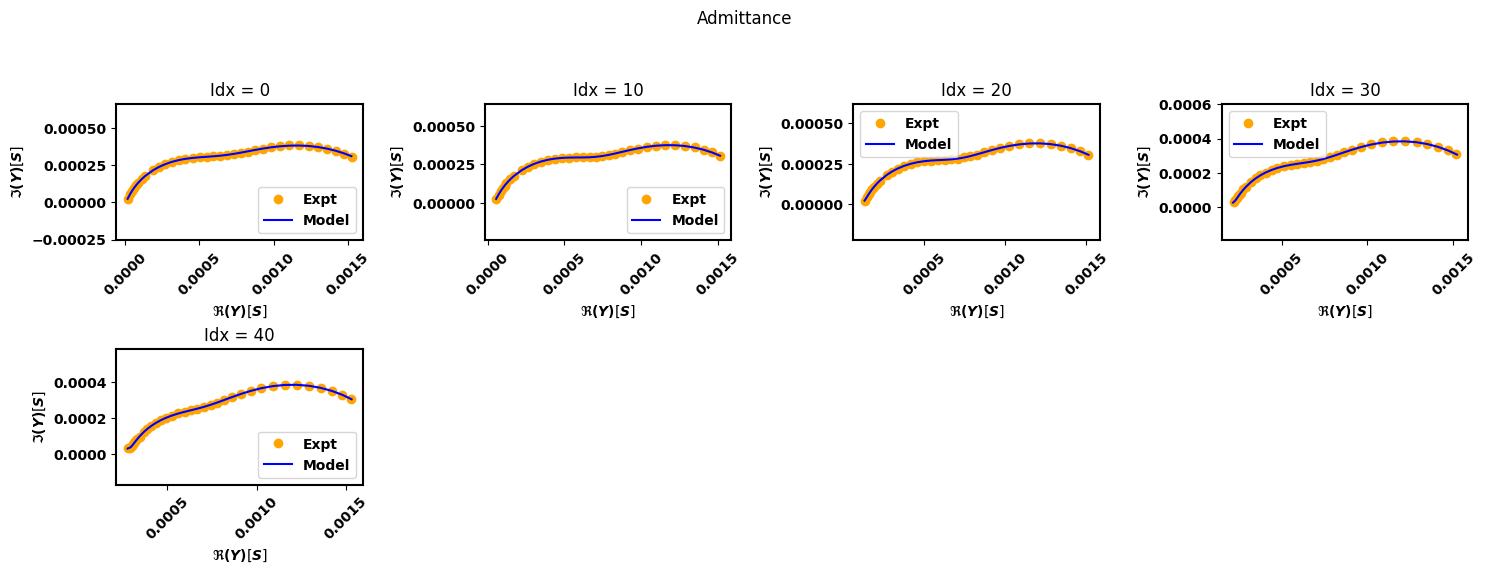

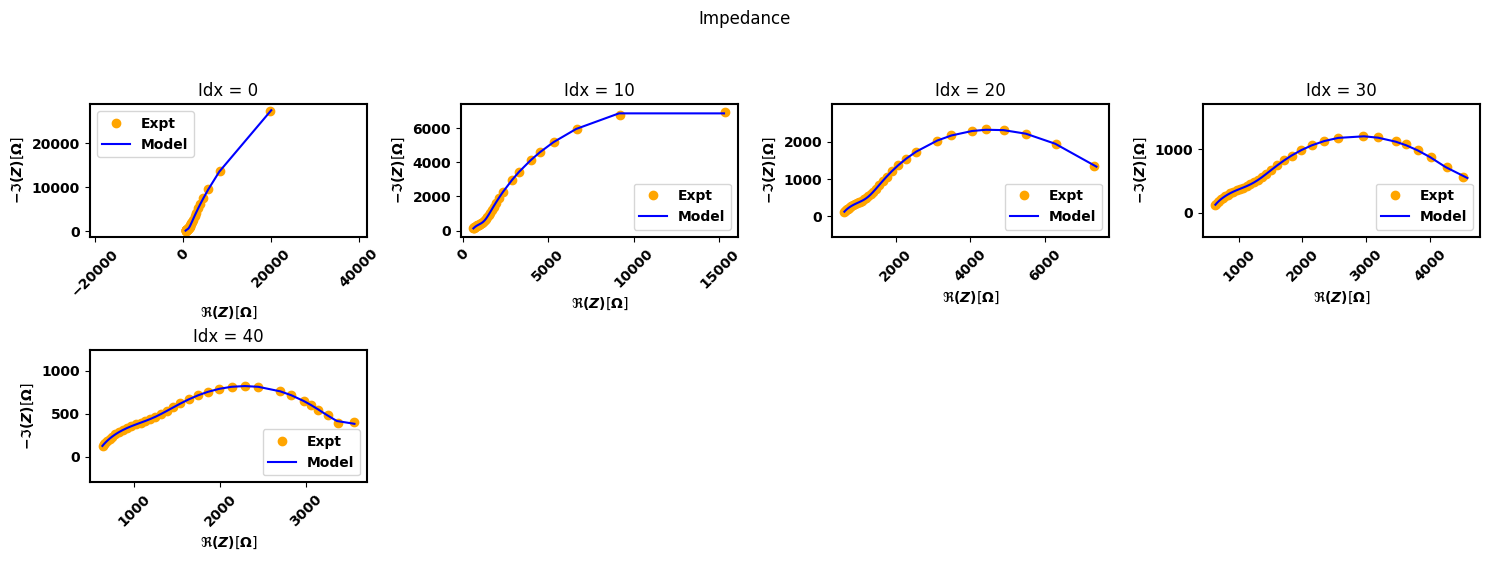

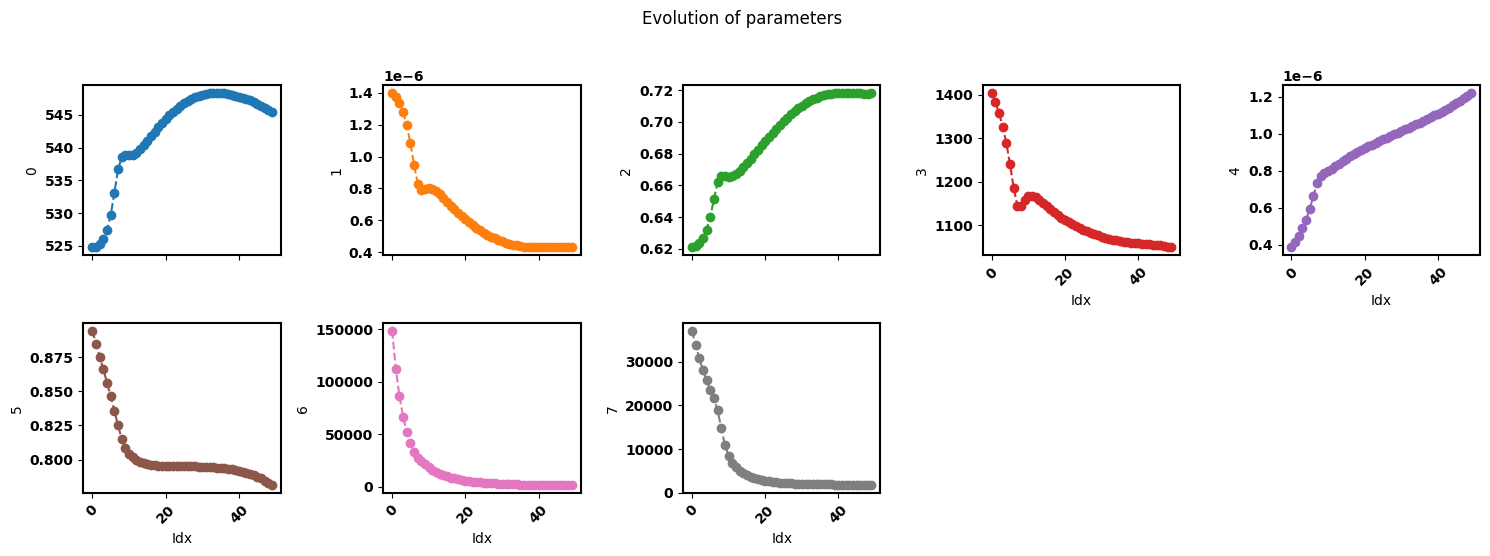

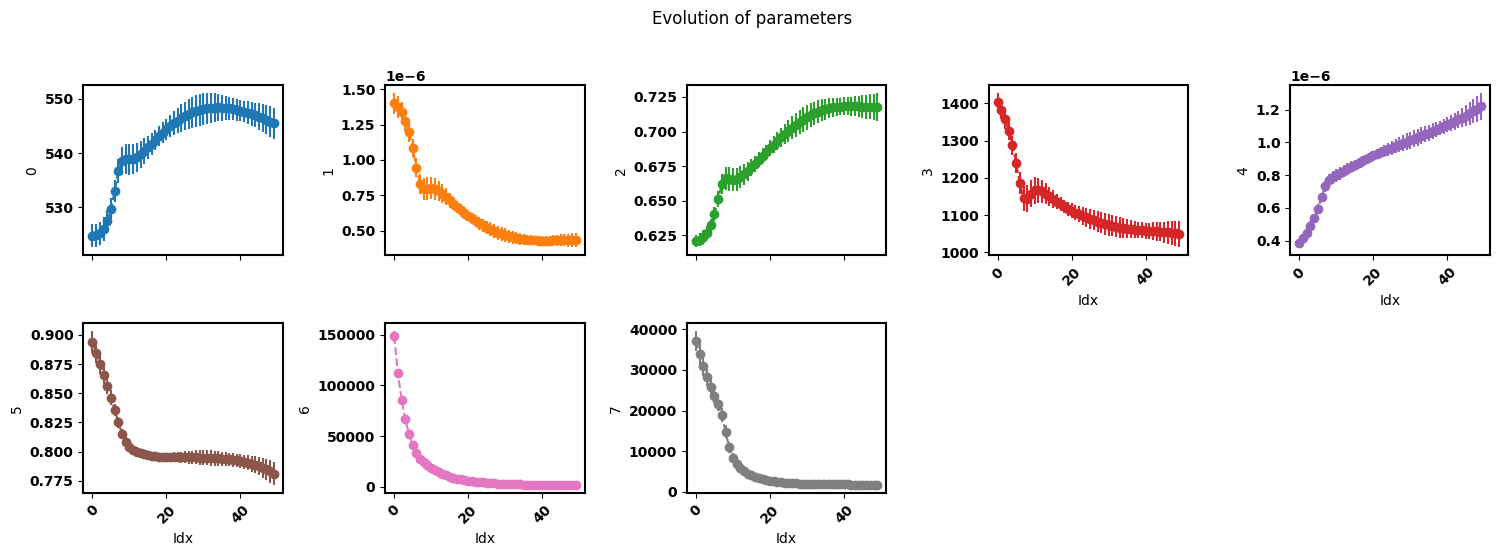

In [10]:
eis_her_simultaneous = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her_simultaneous.fit_simultaneous()
popt, perr, chisqr, chitot, AIC = eis_her_simultaneous.fit_simultaneous_zero()
eis_her_simultaneous.plot_nyquist(10)
eis_her_simultaneous.plot_params()
eis_her_simultaneous.plot_params(show_errorbar=True)